具体改动和使用方法见/content/Grounding-DINO-SAM-Amodal-3R-in-colab/README.md  
运行打开GPU运行时，根据单元格执行

1.虚拟python3.10环境以适配amodal3R

In [ ]:
import sys
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py310_23.11.0-1-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y python=3.10
sys.path.append('/usr/local/lib/python3.10/site-packages')
!python --version  #应该是Python 3.10.x

--2025-04-11 16:47:16--  https://repo.anaconda.com/miniconda/Miniconda3-py310_23.11.0-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134381165 (128M) [application/octet-stream]
Saving to: ‘mini.sh’

mini.sh             100%[===================>] 128.16M   162MB/s    in 0.8s    

2025-04-11 16:47:17 (162 MB/s) - ‘mini.sh’ saved [134381165/134381165]

PREFIX=/usr/local
Unpacking payload ...
                                                                                 
Installing base environment...





Preparing transaction: - \ | done
Executing transaction: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
installation finished.
    You currently have a PYTHONPATH environment variabl

2.引入必要仓库

In [ ]:
!git clone https://github.com/michaelz9436/Grounding-DINO-SAM-Amodal-3R-in-colab.git /content/Grounding-DINO-SAM-Amodal-3R-in-colab
!apt-get install git-lfs
!git clone https://huggingface.co/spaces/Sm0kyWu/Amodal3R
!pip install --upgrade -q git+https://github.com/huggingface/transformers

#复制example
import shutil
shutil.copytree('/content/Grounding-DINO-SAM-Amodal-3R-in-colab/example', '/content/example')

Cloning into '/content/Grounding-DINO-SAM-Amodal-3R-in-colab'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 46 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 5.65 MiB | 26.18 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Cloning into 'Amodal3R'...
remote: Enumerating objects: 1145, done.
remote: Counting objects: 100% (1145/1145), done.
remote: Compressing objects: 100% (1064/1064), done.
remote: Total 1145 (delta 427), reused 354 (delta 68), pack-reused 0 (from 0)
Receiving objects: 100% (1145/1145), 805.15 KiB | 20.64 MiB/s, done.
Resolving deltas: 100% (427/427), done.
  Installing build dependencies ... done
  Getting req

'/content/example'

In [ ]:
# 安装 requirements.txt 中的所有依赖，虚拟环境
!python3.10 -m pip install -r /content/Amodal3R/requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
Looking in links: https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.4.0_cu121.html
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6zs69yhe
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6zs69yhe
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/EasternJournalist/utils3d.git (to revision 9a4eb15e4021b67b12c460c7057d642626897ec8) to /tmp/pip-req-build-ypur29hl
  Running command git clone --filter=blob:none --quiet https://github.com/EasternJournalist/utils3d.git /tmp/pip-req-build-ypur29hl
  Running command git rev-parse -q --verify 'sha^9a4eb15e4021b67b12c460c7057d642626897ec8'
  Running command git fetch -q https://github.com/EasternJou

3.这部分是使用Grouding DINO SAM生成Amodal3R支持的mask和image

In [ ]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple
import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline
dataclass
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))


def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()
def random_named_css_colors(num_colors: int) -> List[str]:
    """
    Returns a list of randomly selected named CSS colors.

    Args:
    - num_colors (int): Number of random colors to generate.

    Returns:
    - list: List of randomly selected named CSS colors.
    """
    # List of named CSS colors
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    # If class_colors is not provided, generate random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]


    fig = px.imshow(image)

    # Add bounding boxes
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        polygon = mask_to_polygon(mask)

        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode='lines',
            line=dict(color=class_colors[idx], width=2),
            fill='toself',
            name=f"{label}: {score:.2f}"
        ))

        xmin, ymin, xmax, ymax = box.xyxy
        shape = [
            dict(
                type="rect",
                xref="x", yref="y",
                x0=xmin, y0=ymin,
                x1=xmax, y1=ymax,
                line=dict(color=class_colors[idx])
            )
        ]
        annotation = [
            dict(
                x=(xmin+xmax) // 2, y=(ymin+ymax) // 2,
                xref="x", yref="y",
                text=f"{label}: {score:.2f}",
            )
        ]

        shapes.append(shape)
        annotations.append(annotation)

    # Update layout
    button_shapes = [dict(label="None",method="relayout",args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}",method="relayout",args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        # margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show plot
    fig.show()
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks
def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    # Refine masks if polygon_refinement is enabled
    masks = refine_masks(masks, polygon_refinement)

    # Store masks in output_mask (as nparray format)
    output_mask = []  # List to store masks in np.array format
    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask
        output_mask.append(mask)  # Add the mask to output_mask

    return detection_results, output_mask  # Returning both detection results and output masks

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections, outputmask = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections, outputmask

def draw_line(mask,kernel_size = 3,num_iter = 3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=num_iter)
    dilated = mask.copy()
    new_image = np.where(eroded == dilated, 255, 0).astype(np.uint8)
    combined_mask = np.where(new_image == 0, 0, eroded)
    return combined_mask


def get_crop_params(mask):
    # 找到灰色（128）部分的位置
    gray_positions = np.where(mask == 128)
    # 如果没有找到灰色区域，返回默认参数
    if len(gray_positions[0]) == 0:
        return (0, 0, mask.shape[0], mask.shape[1],mask)
    maskx, masky = mask.shape[0], mask.shape[1]
    print(mask.shape)

    min_x = np.min(gray_positions[1])  # 最小x坐标
    max_x = np.max(gray_positions[1])  # 最大x坐标
    min_y = np.min(gray_positions[0])  # 最小y坐标
    max_y = np.max(gray_positions[0])  # 最大y坐标

    shape = (max_x-min_x, max_y-min_y)

    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2

    crop_size = int(max(shape[0],shape[1])*1.5)
    if crop_size > min(maskx,masky):
        return (0, 0, mask.shape[0], mask.shape[1],mask)
    crop_half_size = crop_size//2

    crop_x1 = center_x - crop_half_size
    crop_y1 = center_y - crop_half_size
    crop_x2 = center_x + crop_half_size
    crop_y2 = center_y + crop_half_size

    if crop_x1 < 0:
        crop_x1 -= crop_x1
        crop_x2 -= crop_x1
    if crop_x2 > maskx:
        out_len = crop_x2 - maskx
        crop_x2 -= out_len
        crop_x1 -= out_len
    if crop_y1 < 0:
        crop_y1 -= crop_y1
        crop_y2 -= crop_y1
    if crop_y2 > masky:
        out_len = crop_y2 - masky
        crop_y2 -= out_len
        crop_y1 -= out_len
    cropped_mask = mask[crop_y1:crop_y2, crop_x1:crop_x2]

    return crop_y1, crop_x1, crop_y2, crop_x2, cropped_mask

def get_final_mask(vis_mask, occ_mask):
  vis_mask[vis_mask == 255] = 128
  vis_mask[vis_mask == 0] = 255 #转灰
  occ_mask = np.where(occ_mask == 0, 255, 0) #转黑
  crop_y1, crop_x1, crop_y2, crop_x2, cropped = get_crop_params(vis_mask)
  processed_vis_mask = draw_line(vis_mask)
  combined_mask = np.where(occ_mask == 0, 0, processed_vis_mask)
  final_mask = combined_mask[crop_y1:crop_y2, crop_x1:crop_x2]
  return final_mask, crop_y1, crop_x1, crop_y2, crop_x2

In [ ]:
"""
更改这个地方
生成对应图片的mask
label输入目标物体和遮挡物体（可选）
"""
image_url = "/content/example/clip (13).jpg"
labels = ["a birdhouse", "hand"]
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

Device set to use cuda


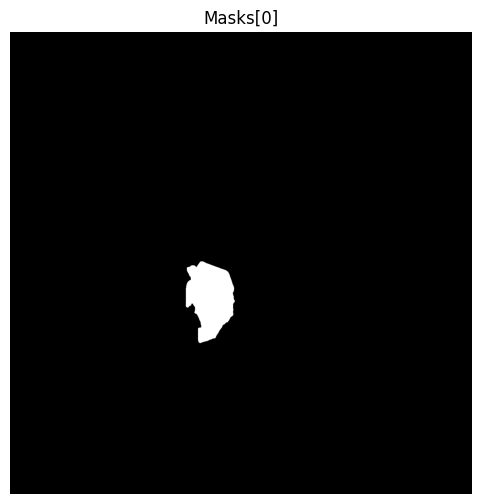

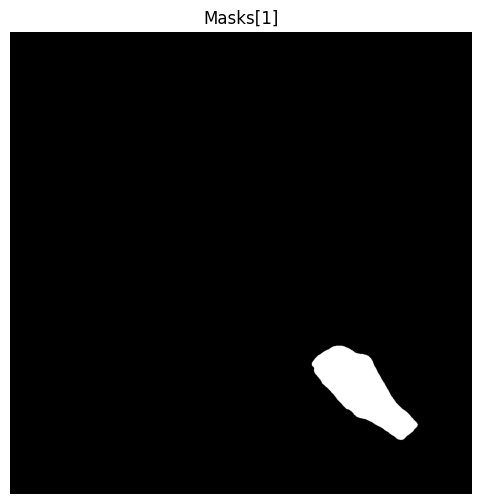

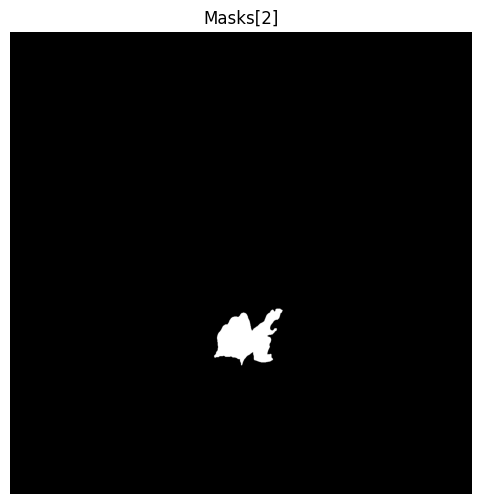

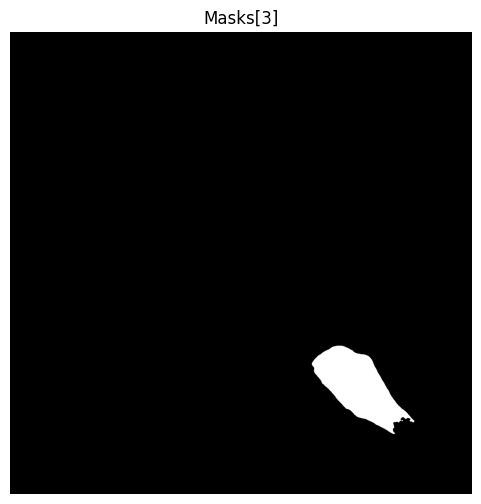

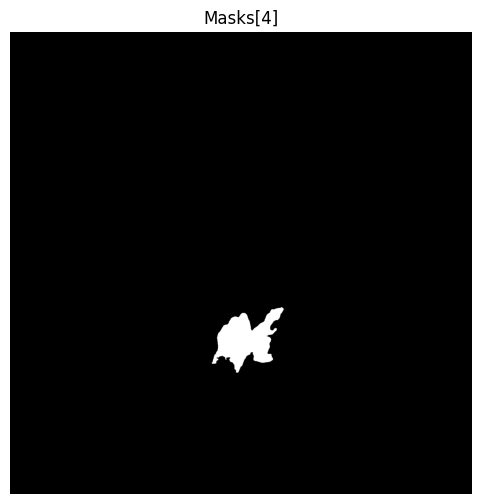

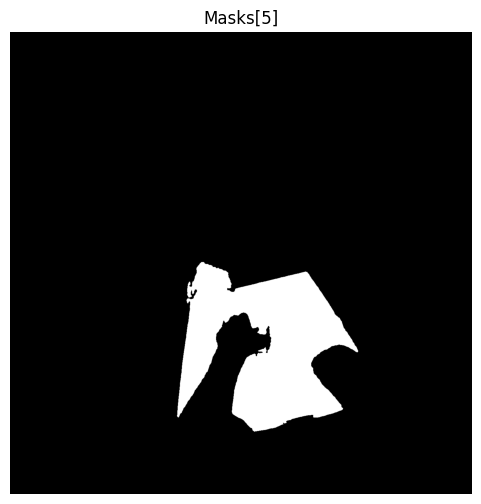

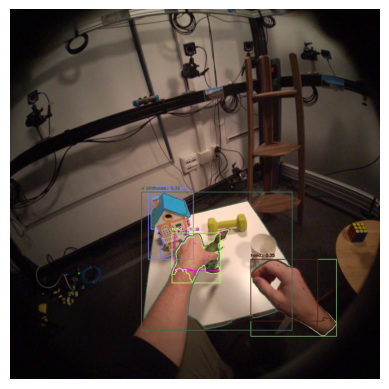

In [ ]:
image_array, detections, masks = grounded_segmentation(
    image=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)
import matplotlib.pyplot as plt

# _mask is the list of masks (nparray)
for idx, mask in enumerate(masks):
    # Create a new figure for each mask
    plt.figure(figsize=(6, 6))

    # Display the mask
    plt.imshow(mask, cmap='gray')

    # Add a title indicating the mask index
    plt.title(f"Masks[{idx}]")

    # Hide axes
    plt.axis('off')

    # Show the plot
    plt.show()

plot_detections(image_array, detections, "result.png")
plot_detections_plotly(image_array, detections)

3.2这个部分是处理mask为Amodal3R接受的格式，根据注释修改下面的前几行代码

(1408, 1408)


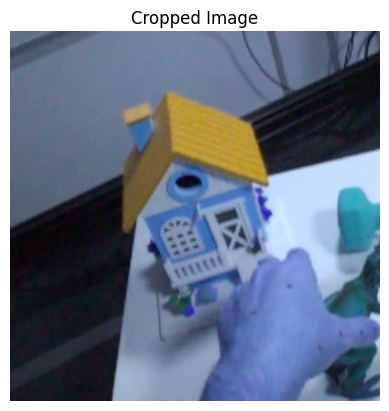

Cropped image saved to: /content/finalreal.png


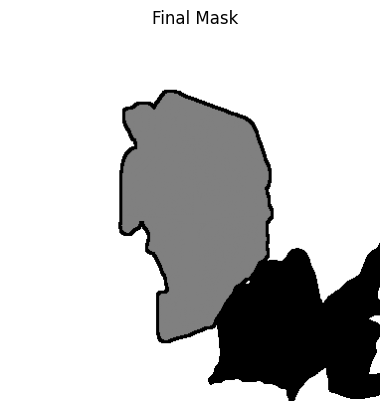

shape: (372, 372)


In [ ]:
"""
更改这个地方设置mask
根据上一个cell输出查看visible mask和occlusion mask分别是什么
else语句是合并mask的，如果occlusion_mask不止一个，把注释删掉可以合成mask
"""
vis_mask = masks[0].copy() #目标物体的mask，以masks[0]为例
if len(masks) == 1:
  occ_mask = np.zeros_like(masks[0])
else:
  occ_mask = masks[2].copy() #遮挡物体的mask
  #occ_mask = np.maximum(occ_mask, masks[2])   #合并mask，需要合并就取消注释
"""
以下代码无需修改
进行裁剪，换色，叠加以适配Amodal3R
"""
vis_mask = vis_mask.astype(np.uint8)
occ_mask = occ_mask.astype(np.uint8)
final_mask, crop_y1, crop_x1, crop_y2, crop_x2 = get_final_mask(vis_mask,occ_mask)

# 保存合并后的 mask
from PIL import Image
final_mask_image = Image.fromarray(final_mask.astype(np.uint8))
final_mask_image.save('/content/finalmask.png')

image_path = image_url
image = cv2.imread(image_path)

# 裁剪图像
cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]

# 保存裁剪结果
save_path = '/content/finalreal.png'
cv2.imwrite(save_path, cropped_image)

##################################### 可视化查看结果 #########################################

plt.imshow(cropped_image, vmin=0, vmax=255)
plt.title('Cropped Image')
plt.axis('off')
plt.show()

print(f"Cropped image saved to: {save_path}")

plt.imshow(final_mask, cmap='gray', vmin=0, vmax=255)
plt.title('Final Mask')
plt.axis('off')
plt.show()

print("shape:",final_mask.shape)

4.进行Amodal3D重建

In [ ]:
# 将 Amodal3R_3Dreconstruction.py 复制到 /content 目录
import shutil
shutil.copy('Grounding-DINO-SAM-Amodal-3R-in-colab/Amodal3R_3Dreconstruction.py', '/content/Amodal3R/Amodal3R_3Dreconstruction.py')
shutil.copy('Grounding-DINO-SAM-Amodal-3R-in-colab/Amodal3R_createmask.py', '/content/Amodal3R/Amodal3R_createmask.py')
# 更改attention类型，如果没必要就注释掉
"""
这个部分是因为colab免费的T4不支持fast_attn，就覆盖__init__，改为xformers
如果你是pro的A100，可以把后面的两行注释掉，使用原来的flash_attn
"""
shutil.copy('/content/Grounding-DINO-SAM-Amodal-3R-in-colab/attn/__init__.py', '/content/Amodal3R/Amodal3R/modules/attention')
shutil.copy('/content/Grounding-DINO-SAM-Amodal-3R-in-colab/sparse/__init__.py', '/content/Amodal3R/Amodal3R/modules/sparse')

'/content/Amodal3R/Amodal3R/modules/sparse/__init__.py'

4.1这个是用Amodal内置的添加点的方法生成mask，如果已经有mask就别管了。
但是我还是写了这个部分的移植，如果想用就在/content/Amodal3R/Amodal3R_3Dreconstruction.py里面更改两种点的list

In [ ]:
#不用运行
!python3 /content/Amodal3R/Amodal3R_createmask.py

[SPARSE] Backend: spconv, Attention: xformers
sam_vit_h_4b8939.pth: 100% 2.56G/2.56G [01:47<00:00, 23.8MB/s]
初始化成功，添加点
sam完成，保存模型
Figure(1000x500)


4.2进行重建，保存打包的结果。在content里面point_cloud.png可以预览结果，或者运行下面的nvdiff部分渲染mesh

Amodal3R的渲染方法在colab里会爆显存

In [ ]:
torch.cuda.empty_cache()
#执行3D重建部分
!python3 /content/Amodal3R/Amodal3R_3Dreconstruction.py

[SPARSE] Backend: spconv, Attention: xformers
[SPARSE][CONV] spconv algo: auto
[ATTENTION] Using backend: xformers
/usr/local/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/usr/local/lib/python3.10/site-packages/spconv/pytorch/functional.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  _TORCH_CUSTOM_FWD = a

接下来是渲染部分:

如果有打包完成的pkl文件，也可以单独运行

In [ ]:
import torch
torch.cuda.empty_cache()
!sudo apt install libglfw3-dev -y
!git clone https://github.com/NVlabs/nvdiffrast.git
%cd nvdiffrast
!pip install .

!pip install ninja
!pip install trimesh imageio
!pip install -q ipywidgets

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libegl-dev libegl1-mesa-dev libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglfw3 libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev
  libvulkan-dev libvulkan1 libwayland-bin libwayland-dev libxrandr-dev
  mesa-vulkan-drivers
Suggested packages:
  libosmesa6 libglfw3-doc libwayland-doc
The following NEW packages will be installed:
  libegl-dev libegl1-mesa-dev libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglfw3 libglfw3-dev libglvnd-core-dev libglvnd-dev libglx-dev
  libopengl-dev libvulkan-dev libvulkan1 libwayland-bin libwayland-dev
  libxrandr-dev mesa-vulkan-drivers
0 upgraded, 18 newly installed, 0 to remove and 30 not upgraded.
Need to get 12.2 MB of archives.
After this operation, 72.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB

初始化渲染器如果中途终止可能会引起colab问题，出现问题需要重启运行时。

In [ ]:
import torch
import pickle
import nvdiffrast.torch as dr
import trimesh
import numpy as np
import matplotlib.pyplot as plt

#设置 CUDA 设备
device = torch.device('cuda')
with open('/content/packed_state.pkl', 'rb') as f:
    data = pickle.load(f)
vertices = data["mesh"]['vertices']  #  N x 3 的列表
faces = data["mesh"]['faces']        #  M x 3 的列表

# 转换为 PyTorch 张量
vertices = torch.tensor(vertices, dtype=torch.float32, device=device)  # 转换为浮点类型张量
faces = torch.tensor(faces, dtype=torch.int32, device=device)           # 转换为整数类型张量

#设置图像尺寸
H, W = 512, 512

# 准备相机参数（透视矩阵 & 视图矩阵）
fov = 60.0
focal = 0.5 * W / np.tan(0.5 * fov * np.pi / 180)
proj = torch.tensor([
    [focal / (W / 2), 0, 0, 0],
    [0, focal / (H / 2), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 1, 0]
], dtype=torch.float32, device=device)

#生成同样数量的 RGB 颜色
colors = torch.ones_like(vertices)  # 全白

#归一化并转换顶点到 NDC
v_h = torch.cat([vertices, torch.ones_like(vertices[:, :1])], dim=-1)
v_clip = (proj @ v_h.T).T  # shape: [N, 4]
v_ndc = v_clip[:, :3] / v_clip[:, 3:4]

#初始化 CUDA 渲染器
rast_ctx = dr.RasterizeCudaContext()

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning:

TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].



In [ ]:
from ipywidgets import interact, FloatSlider
import math

def render(cam_x=0.0, cam_y=0.0, cam_z=3.0, yaw=0.0, pitch=0.0, z=0.0):
    #构造旋转矩阵（绕Y轴的yaw，绕X轴的pitch，绕Z轴的z）
    yaw_rad = math.radians(yaw)
    pitch_rad = math.radians(pitch)
    z_rad = math.radians(z)

    # 绕Y轴旋转（水平旋转）
    R_y = torch.tensor([
        [math.cos(yaw_rad), 0, math.sin(yaw_rad), 0],
        [0, 1, 0, 0],
        [-math.sin(yaw_rad), 0, math.cos(yaw_rad), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32, device=device)

    # 绕X轴旋转（垂直旋转）
    R_x = torch.tensor([
        [1, 0, 0, 0],
        [0, math.cos(pitch_rad), -math.sin(pitch_rad), 0],
        [0, math.sin(pitch_rad), math.cos(pitch_rad), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32, device=device)
    #绕Z轴
    R_z = torch.tensor([
    [math.cos(z_rad), -math.sin(z_rad), 0, 0],
    [math.sin(z_rad), math.cos(z_rad), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ], dtype=torch.float32,device = device)


    #平移矩阵
    translate = torch.eye(4, dtype=torch.float32, device=device)
    translate[0, 3] = -cam_x
    translate[1, 3] = -cam_y
    translate[2, 3] = -cam_z

    #相机变换 = 平移 @ 旋转
    view = translate @ (R_z @ R_y @ R_x)


    #顶点转换到齐次空间
    v_h = torch.cat([vertices, torch.ones_like(vertices[:, :1])], dim=-1)
    v_clip = (proj @ view @ v_h.T).T
    v_ndc = v_clip[:, :3] / v_clip[:, 3:4]

    #使用法线方向着色（增强空间感）
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    face_normals = torch.nn.functional.normalize(torch.cross(v1 - v0, v2 - v0), dim=1)

    #把每个面法线扩展为三个顶点的颜色（每个面3个点）
    face_colors = face_normals.repeat_interleave(3, dim=0)

    #用面着色为每个顶点上色
    colors = torch.zeros_like(vertices)
    colors[faces.reshape(-1)] = face_colors

    #构建齐次坐标 & 渲染
    ones = torch.ones(v_ndc.shape[0], 1).to(v_ndc.device)
    v_ndc_homogeneous = torch.cat([v_ndc, ones], dim=1).contiguous()

    rast_out, _ = dr.rasterize(rast_ctx, v_ndc_homogeneous.unsqueeze(0), faces, (H, W))
    attr = colors.unsqueeze(0).contiguous()
    color_out, _ = dr.interpolate(attr, rast_out, faces)
    color_out = dr.antialias(color_out, rast_out, v_ndc_homogeneous.unsqueeze(0), faces)

    #显示图像
    img = color_out[0].clamp(0, 1).cpu().numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('nvdiffrast Mesh Rendering')
    plt.show()

#创建滑块交互界面
interact(render,
         cam_x=FloatSlider(min=-5, max=5, step=0.1, value=0.0, description='cam_x'),
         cam_y=FloatSlider(min=-5, max=5, step=0.1, value=0.0, description='cam_y'),
         cam_z=FloatSlider(min=0.1, max=10, step=0.1, value=3.0, description='cam_z'),
         yaw=FloatSlider(min=-180, max=180, step=1, value=0.0, description='yaw'),
         pitch=FloatSlider(min=-90, max=90, step=1, value=0.0, description='pitch'),
         z=FloatSlider(min=-90, max=90, step=1, value=0.0, description='z'));


interactive(children=(FloatSlider(value=0.0, description='cam_x', max=5.0, min=-5.0), FloatSlider(value=0.0, d…

这部分是生成渲染视频，角度可以根据上面的输出调整

In [ ]:
import imageio
import os
import matplotlib.pyplot as plt
from PIL import Image
import shutil
def render2(cam_x=0.0, cam_y=0.0, cam_z=3.0, yaw=0.0, pitch=0.0, z=0.0):
    yaw_rad = math.radians(yaw)
    pitch_rad = math.radians(pitch)
    z_rad = math.radians(z)

    R_y = torch.tensor([
        [math.cos(yaw_rad), 0, math.sin(yaw_rad), 0],
        [0, 1, 0, 0],
        [-math.sin(yaw_rad), 0, math.cos(yaw_rad), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32, device=device)

    R_x = torch.tensor([
        [1, 0, 0, 0],
        [0, math.cos(pitch_rad), -math.sin(pitch_rad), 0],
        [0, math.sin(pitch_rad), math.cos(pitch_rad), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32, device=device)

    R_z = torch.tensor([
    [math.cos(z_rad), -math.sin(z_rad), 0, 0],
    [math.sin(z_rad), math.cos(z_rad), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ], dtype=torch.float32,device = device)

    translate = torch.eye(4, dtype=torch.float32, device=device)
    translate[0, 3] = -cam_x
    translate[1, 3] = -cam_y
    translate[2, 3] = -cam_z
    view = translate @ (R_z @ R_y @ R_x)

    v_h = torch.cat([vertices, torch.ones_like(vertices[:, :1])], dim=-1)
    v_clip = (proj @ view @ v_h.T).T
    v_ndc = v_clip[:, :3] / v_clip[:, 3:4]
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    face_normals = torch.nn.functional.normalize(torch.cross(v1 - v0, v2 - v0), dim=1)
    face_colors = face_normals.repeat_interleave(3, dim=0)

    colors = torch.zeros_like(vertices)
    colors[faces.reshape(-1)] = face_colors

    ones = torch.ones(v_ndc.shape[0], 1).to(v_ndc.device)
    v_ndc_homogeneous = torch.cat([v_ndc, ones], dim=1).contiguous()

    rast_out, _ = dr.rasterize(rast_ctx, v_ndc_homogeneous.unsqueeze(0), faces, (H, W))
    attr = colors.unsqueeze(0).contiguous()
    color_out, _ = dr.interpolate(attr, rast_out, faces)
    color_out = dr.antialias(color_out, rast_out, v_ndc_homogeneous.unsqueeze(0), faces)
    img = color_out[0].clamp(0, 1).cpu().numpy()
    return img

# 创建帧目录
os.makedirs("/content/frames", exist_ok=True)
# 帧列表
frames = []

for yaw_angle in range(-180, 0):
    # 渲染当前帧图像
    yaw = float(yaw_angle)

    # 渲染当前帧图像
    img = render2(cam_x=0.0, cam_y=0.0, cam_z=1.1, yaw=yaw, pitch=-55, z=-19)

    # 创建新的图形
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(img)

    # 保存当前帧图像
    frame_path = f"/content/frames/frame_{yaw_angle + 180:03d}.png"
    plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # 关闭当前图形
    frames.append(frame_path)

# 生成视频
video_path = "/content/yaw_rotation.mp4"
with imageio.get_writer(video_path, fps=30) as writer:
    for frame_file in frames:
        image = imageio.imread(frame_file)
        writer.append_data(image)

print(f"视频已保存到：{video_path}")


# 指定要清空的目录
frame_dir = '/content/frames'

# 检查该目录是否存在
if os.path.exists(frame_dir):
    # 清空目录中的所有文件和文件夹
    for filename in os.listdir(frame_dir):
        file_path = os.path.join(frame_dir, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)  # 删除文件夹及其内容
            else:
                os.remove(file_path)  # 删除文件
        except Exception as e:
            print(f"删除 {file_path} 时发生错误: {e}")
    print(f"清空了目录 {frame_dir}")
else:
    print(f"目录 {frame_dir} 不存在")

<ipython-input-43-b1d8f40a2537>:110: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

<ipython-input-43-b1d8f40a2537>:117: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



视频生成成功，保存路径：/content/yaw_rotation_with_side_image.mp4
✅ 视频已保存到：/content/yaw_rotation_with_side_image.mp4
✅ 清空了目录 /content/frames
